<a href="https://colab.research.google.com/github/Ankandas14/Computer_Vision_DL/blob/main/CFAIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
!pip install torchinfo
!pip install torchmetrics
from torchinfo import summary
from torchmetrics import Accuracy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# If CUDA is available, print the CUDA device name
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cpu


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the classes in the dataset:

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck

Data Preparation and Augmentation

1. transforms.RandomCrop(32, padding=4): Randomly crops the image to a size of 32x32 pixels after padding it by 4 pixels.
2. transforms.RandomHorizontalFlip(): Randomly flips the image horizontally.

3. transforms.ToTensor(): Converts the image from a PIL Image or NumPy array to a PyTorch tensor.





In [ ]:
# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [ ]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

In [ ]:
class_names = train_data.classes

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

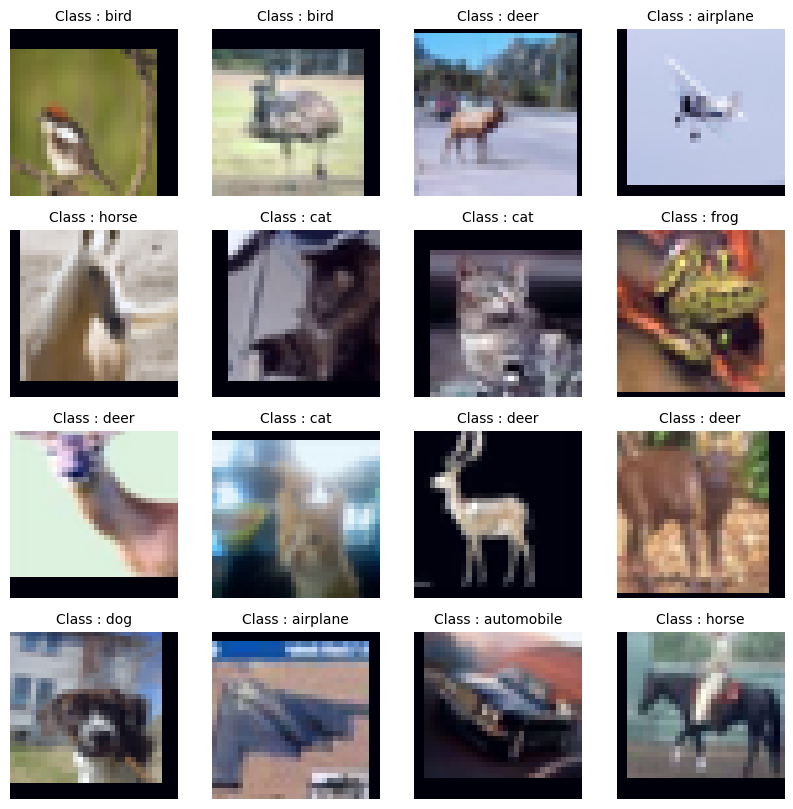

In [ ]:
## look into the data we've downloaded
import random

rand_idx = random.sample(range(len(train_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_data[idx]

  #the image tensor's range is not between 0 and 1,so we have to temporarily scale the tensor values into range 0 and 1 to prevent error.
  img = (img - img.min()) / (img.max() - img.min())

  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

Load the Data

In [ ]:
NUM_WORKERS = os.cpu_count()
print(f'Number of workers: {NUM_WORKERS}')
BATCH_SIZE = 800

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

Number of workers: 2


In [ ]:
# train loop function
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               scheduler:torch.optim.lr_scheduler = None,
               grad_clip:float=None):

  model.train()

  train_loss , train_acc = 0 , 0

  for batch , (X,y) in enumerate(dataloader):

    X , y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()
    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss)


  return train_loss , train_acc

In [ ]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):

  model.eval()

  test_loss , test_acc = 0 , 0

  with torch.inference_mode():
    for batch , (X,y) in enumerate(dataloader):
      X , y = X.to(device) , y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      test_pred_labels = torch.argmax(test_pred_logits,dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss , test_acc

In [ ]:
#Creating a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          grad_clip:float=None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler,
                                           grad_clip=grad_clip)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
# function to plot loss & accuracy curve
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):


    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()


    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

RESNET

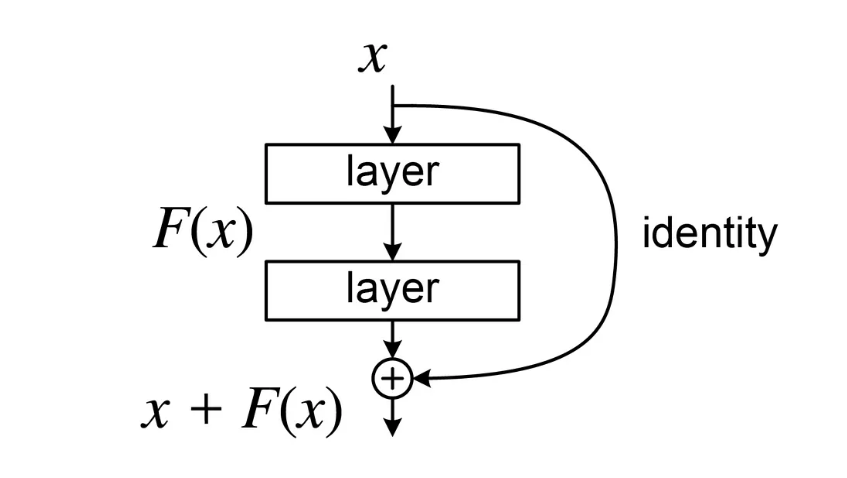

In [ ]:
# create Resnet model class

class ResNet9(nn.Module):
    def conv_block(self, input_channels, output_channels, use_pool=False):
        layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(output_channels),
                  nn.ReLU(inplace=True)]
        if use_pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def __init__(self, input_channels, number_classes):
        super().__init__()

        self.conv1 = self.conv_block(input_channels, 64)
        self.conv2 = self.conv_block(64, 128, use_pool=True)
        self.residual1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, use_pool=True)
        self.conv4 = self.conv_block(256, 512, use_pool=True)
        self.residual2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, number_classes))

    def forward(self, xb):
        layer1 = self.conv1(xb)
        layer2 = self.conv2(layer1)
        residual1 = self.residual1(layer2) + layer2
        layer3 = self.conv3(residual1)
        layer4 = self.conv4(layer3)
        residual2 = self.residual2(layer4) + layer4
        class_output = self.classifier(residual2)
        return class_output

In [ ]:
model_0 = ResNet9(3,10).to(device)
#[batch_size,color_channels,width,height]
summary(model_0, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 32, 32]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 32, 32]          256
│    └─ReLU: 2-6                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-7                    [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Sequential: 2-8                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          147,584
│

Hyperparameters Tunning

NUM_EPOCHS : how many times the whole set of training data will run through the neural network
learning_rate : s like adjusting how big of a step the model takes when it's learning
weight_decay : model's weight values
grad_clip

In [ ]:
# Let's train
NUM_EPOCHS = 20
learning_rate = 0.01
weight_decay = 15e-5
grad_clip = 0.0001

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',verbose=True,factor=0.3,patience=3,threshold=0.09)


from timeit import default_timer as timer
start_time = timer()


model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]